In [1]:
import sys
import xlrd
import pandas as pd
import numpy as np
from numpy import median
import os
import fnmatch 
import random
import matplotlib.pyplot as plt
import numpy.polynomial.polynomial as poly
import plotly.graph_objects as go
import plotly.express as px
from scipy import stats
import statistics
from scipy import signal
import math
from sklearn.linear_model import LinearRegression

## Change num_c: test with [10, 15, 20] num_c is codon sliding window(continuous)
## Calculate elongation rate by different num_c

In [32]:
cwd = os.getcwd()
print(cwd)
# Ribosome counts directory
#Ribocsv_dir = cwd+'/output/Glu_readd/EY-Ribo/'
Ribocsv_dir = cwd+'/output/Anna/'
# Polarity directory
polcsv_dir = cwd+'/outputcsv/Anna/'
#polcsv_dir = cwd+'/outputcsv/Glu_readd/EY-Ribo/'
# mRNA counts directory
RNAcsv_dir = cwd+'/output/Glu_readd/EY-RNA/'
# Delta Dhh1 file
dhh1file = cwd+'/Dhh1_Length_Short.xlsx'

# Define range of calculation samples and labels in bp
exclude1 = 0
exclude2 = 0
viewer = 1000*3
names = ['811','813', '815','817']
labels = ['logphase', '-Glu01','-Glu05', '-Glu15']
#names = ['15','7516','1517', '15118','15529']
#labels = ['logphase', '-Glu075','-Glu15', '-Glu15+Glu1','-Glu15+Glu5']

# Range of genes: length in bp
d1 = 1500
d2 = 7654321
# codon sliding window
num_c = 5
# Dhh1 tag all, enriched, depleted
dhh1_tag = 'enriched'


df_samples_readd = pd.DataFrame()
df_samples_stress = pd.DataFrame()
stress = []
readd = []
dict_samples = []
med_rs = []

/Users/jiz225/Desktop/ZidLab/polarity


In [33]:
## Load data and find concensus genes in length range
red = ['YLL026W', 'YDR258C', 'YPL240C', 'YBR169C', 'YER103W', 
       'YGR142W', 'YDR171W', 'YCR021C', 'YBR072W', 'YFL014W', 'YLR327C']
isred = []
df_dhh1_all = pd.read_excel(dhh1file)
df_dhh1_all = df_dhh1_all.set_index('Name')
for i in df_dhh1_all.index:
    if i in red:
        isred.append('y')
    else:
        isred.append('n')
df_dhh1_all['Type'] = isred
namelist = df_dhh1_all.index

polcsv_list=[]
tag = 'longmers_deduplicated_sorted_aligned_coding_NI-'
for root,dirs,files in os.walk(polcsv_dir):
    for file in files:
        if file.split('.')[-1] == "csv" and tag in file:
            polcsv_list.append(polcsv_dir + file)
            df = pd.read_csv(polcsv_dir + file)
            d2 = min(d2, max(df.Length))
            df = df[(df.Length >= d1)&(df.Length <= d2)]
            namelist = list(set(namelist) & set(df.Name))
            
Ribocsv_list_s=[]
tag = 'longmers_deduplicated_sorted_aligned_coding_NI-'
#tag = 'Ribo'
for root,dirs,files in os.walk(Ribocsv_dir):
    for n in names:
        for file in files: 
            time = ''
            if file.split('.')[-1] == "csv" and tag in file:
                time = ''.join(filter(lambda i: i.isdigit(), file.split('/')[-1].split(tag)[1].split('.csv')[0])) 
            if time == n:
                print(time)
                Ribocsv_list_s.append(Ribocsv_dir + file)
print('all files to measure in ' + Ribocsv_dir + ' is ',len(Ribocsv_list_s))

811
813
815
817
all files to measure in /Users/jiz225/Desktop/ZidLab/polarity/output/Anna/ is  4


In [34]:
df_dhh1 = df_dhh1_all[df_dhh1_all.index.isin(namelist)] 
print('total number of genes: ', len(df_dhh1))
spread_dhh1 = df_dhh1.Delta_Dhh1.quantile([0.25,0.5,0.65,0.75])
print(spread_dhh1)
low = spread_dhh1.get(key=0.25)
med = spread_dhh1.get(key=0.5)
high = spread_dhh1.get(key=0.75)

dhh1_enrich = df_dhh1[(df_dhh1.Delta_Dhh1 > med)]
dhh1_deplet = df_dhh1[(df_dhh1.Delta_Dhh1 < med)]
dhh1_all = df_dhh1[(df_dhh1.Delta_Dhh1 > low)&(df_dhh1.Delta_Dhh1 < high)]
print('dhh1 enriched genes(-G-+G) ',len(dhh1_enrich))
print('dhh1 depleted genes(-G-+G) ',len(dhh1_deplet))
print('dhh1 all genes(-G-+G) ',len(dhh1_all))

if dhh1_tag == 'enriched':
    namelist = dhh1_enrich.index.tolist()
if dhh1_tag == 'depleted':
    namelist = dhh1_deplet.index.tolist()
if dhh1_tag == 'all':
    namelist = dhh1_all.index.tolist()

print(dhh1_tag, len(namelist))

total number of genes:  1099
0.25    0.123014
0.50    0.488480
0.65    0.700881
0.75    0.875240
Name: Delta_Dhh1, dtype: float64
dhh1 enriched genes(-G-+G)  549
dhh1 depleted genes(-G-+G)  549
dhh1 all genes(-G-+G)  549
enriched 549


In [35]:
def update_df(sample_agg_dict,df_samples,sample_time):
    temp_df = pd.DataFrame.from_dict(data = {'codon': list(sample_agg_dict.keys()), sample_time: list(sample_agg_dict.values())})
    temp_df = temp_df.set_index('codon')
    if len(df_samples) > 0: 
        #df_samples = pd.merge(df_samples, temp_df, how='inner', on = 'codon')
        df_samples = pd.merge(df_samples, temp_df, left_index=True, right_index=True)
    else:
        df_samples = temp_df  
    
    return df_samples

def smooth_codon(viewer,sample_rbf_dict,sample_label,i):
    global df_samples_readd,df_samples_stress,stress,readd
    
    sf = sample_rbf_dict[(sample_rbf_dict.index >= 1500)&(sample_rbf_dict.index <= 3000)].NormCountsbp.mean(axis=0)
    print(sf)
    # Smooth by codon sliding window
    reads = 0
    num_pos  = 0
    agg_dict = dict()
    for c in range(viewer):
        if c in sample_rbf_dict.index:
            left_c = max(1,c - int(num_c*3/2))
            right_c = c + int(num_c*3/2) + 1
            reads = sample_rbf_dict.loc[left_c:right_c,'NormCountsbp'].mean(axis=0) 
            agg_dict.update({c/3:reads/sf})
            reads = 0
    # avg reads normalized ribosome reads per bp(not smoothed with codon window).
    countsbp = np.array(list(agg_dict.values()))
    sample_std = np.std(countsbp)
    sample_mean = np.mean(countsbp)
    sample_var = sample_std/sample_mean
    counts_distribution = np.quantile(countsbp,[0.05,0.25,0.5,0.75,0.95])
    
    if '+Glu' in sample_label: 
        df_samples_readd = update_df(agg_dict,df_samples_readd,sample_label)
        readd.append(sample_label)
    elif '-Glu15' in sample_label:
        df_samples_stress = update_df(agg_dict,df_samples_stress,sample_label)
        stress.append(sample_label)
        df_samples_readd = update_df(agg_dict,df_samples_readd,sample_label)
        readd.append(sample_label)
    else:
        df_samples_stress = update_df(agg_dict,df_samples_stress,sample_label)
        stress.append(sample_label)
        
    return counts_distribution,sample_std,sample_var
        

In [36]:
times = []
med = []
df_samples_readd = pd.DataFrame()
df_samples_stress = pd.DataFrame()
stress = []
readd = []
dict_samples = []
med_rs = []

for i in range(len(Ribocsv_list_s)):
    file = Ribocsv_list_s[i]
    time = ''.join(filter(lambda i: i.isdigit(), file.split('/')[-1].split('.csv')[0])) 
    label = labels[names.index(time)]
    print(label)
    times.append(label)
    df = pd.read_csv(file)
    df = df[(df.Name.isin(namelist))]
    
    df_1 = df[(df.RelativePosition <= df.Length - exclude2)&(df.RelativePosition >= exclude1)]
    reads_dict = df_1.groupby(['Name']).agg({'Counts': np.sum,'RelativePosition':pd.Series.nunique,'Length':np.mean})
    reads_dict['ReadDensity'] = reads_dict['Counts']/reads_dict['RelativePosition']

    # Normalize raw ribosome reads by avg reads/read position (Gene specific)
    counts = []
    for k in range(len(df)):
        name = df.iloc[k,0]
        count = df.iloc[k,-1]
        counts.append(count/reads_dict.loc[name,'ReadDensity'])
    df['NormCounts'] = counts  
    
    # Aggreggate by position
    rbf_dict = df.groupby(['RelativePosition']).agg({"NormCounts": np.sum, "Name": pd.Series.nunique})
    rbf_dict['NormCountsbp'] = rbf_dict['NormCounts']/rbf_dict['Name']
    
    # merge all samples
    counts_distribution,sample_std,sample_var = smooth_codon(viewer,rbf_dict,label,i)
        
    print('In sample ', label, ' number of genes used ', len(reads_dict.Counts))
    print('In sample ', label, ' number of positions covered ', len(rbf_dict))
    print('In sample ', label, ' variability of avg reads normed ribosome reads per bp is',sample_std,sample_var)
    print('In sample ', label, ' distribution of avg reads normed ribosome reads per bp is')
    print(counts_distribution)    
        

logphase
0.9898523965817609
In sample  logphase  number of genes used  549
In sample  logphase  number of positions covered  6587
In sample  logphase  variability of avg reads normed ribosome reads per bp is 0.04765091990021788 0.047376846538741774
In sample  logphase  distribution of avg reads normed ribosome reads per bp is
[0.93556973 0.97479267 1.00486805 1.03643543 1.0791947 ]
-Glu01
1.005305346052476
In sample  -Glu01  number of genes used  549
In sample  -Glu01  number of positions covered  7413
In sample  -Glu01  variability of avg reads normed ribosome reads per bp is 0.0894472109519106 0.09116492217047549
In sample  -Glu01  distribution of avg reads normed ribosome reads per bp is
[0.74626303 0.9628845  1.0018367  1.03231637 1.0768989 ]
-Glu05
1.0248658173424186
In sample  -Glu05  number of genes used  549
In sample  -Glu05  number of positions covered  7043
In sample  -Glu05  variability of avg reads normed ribosome reads per bp is 0.09251269233061561 0.0958039206924816
In s

In [37]:
df_samples = df_samples_stress
for col in df_samples:
    if col not in stress:
        df_samples = df_samples.drop(columns = [col])

select_times = df_samples.columns[-4:]
df_samples_all = df_samples.loc[:,select_times]

In [38]:
fig = go.Figure()
all_l = []
meds = []
rng = d1
time_course = [0,1*60, 5*60, 15*60]
prev_peak = 0
el_y = 0
el_x = []
peaks = []
rates = []
for i in range(len(select_times)):
    t = select_times[i]
    #t = times[i]+'_normed'
    fit_y = df_samples_all[t]
    fig.add_trace(go.Scatter(x=df_samples_all.index, y = fit_y,mode='lines',name= t.split('_')[0]))

fig.update_layout(
    template='simple_white',
    title_text="Normalized ribosome reads at codon position for " +dhh1_tag+ " genes between " + str(d1) + "bp and " + str(d2)+ "bp",
    xaxis_title="Codon position(" + str(num_c) + " codons sliding window)",
    yaxis_title="Normalized ribosome reads(unsmoothed)"
)       

fig.update_xaxes(range=[15/3, int(2000/3)])

fig.show()

In [39]:
fig = go.Figure()
all_l = []
meds = []
rng = d1
time_course = [0,1*60, 5*60, 15*60]
prev_peak = 0
el_y = 0
el_x = []
peaks = []
rates = []
for i in range(len(select_times)):
    t = select_times[i]
    if i == 0:
        name= 'reference'
        t_prev = select_times[0]
    else:
        name= 'delta ' + t.split('_')[0]
        t_prev = select_times[i-1]
        
    fit_y = df_samples_all[t]-df_samples_all[t_prev]
    fig.add_trace(go.Scatter(x=df_samples_all.index, y = fit_y,mode='lines',name = name))

fig.update_layout(
    template='simple_white',
    title_text="Possible elongation SL in " +dhh1_tag+ " genes between " + str(d1) + "bp and " + str(d2)+ "bp",
    xaxis_title="Codon position(" + str(num_c) + " codons sliding window)",
    yaxis_title="Delta Normalized ribosome reads(unsmoothed)"
)       

fig.update_xaxes(range=[15/3, int(2000/3)])
fig.update_yaxes(range=[-0.5, 0.3])

fig.show()

In [40]:
def estimate_runoff_by_ratio(L_c,i,discrete):
    global df_readd_ratio,df_stress_ratio,time_course, select_times,skips 
    t = select_times[i]
    t_insec = time_course[i]
    skip = skips[i]
    
    ratio_dict = dict()
    runoff_dict = dict()
    rate_dict = dict()
    prev_l = skip/3
    prev_t = 0.0
    prev_r = 1.0
    
    for l in L_c:
        if l <= prev_l:
            avgread_t = 2.0
            avgread_0 = 1.0
            
        else:
            if discrete == False:
                df_t = df_samples_all[(df_samples_all.index > skip/3)&(df_samples_all.index <= l)][t]
                df_0 = df_samples_all[(df_samples_all.index > skips[0]/3)&(df_samples_all.index <= l)][select_times[0]]
                
            
            avgread_t = statistics.mean(df_t)
            avgread_0 = statistics.mean(df_0)
        
        ratio = avgread_t/avgread_0
        runoff_t = t_insec/(prev_r-ratio)
        rate = (l-prev_l)/(runoff_t-prev_t)
        
        
        if ratio < 1.0 and runoff_t > 0:
            ratio_dict.update({l:ratio})
            runoff_dict.update({l:runoff_t})
            rate_dict.update({l:rate})
            prev_l = l
            prev_t = runoff_t
        
    if '+Glu' in t: 
        df_readd_ratio = update_df(ratio_dict,df_readd_ratio,t+'_ratio')
        df_readd_ratio = update_df(runoff_dict,df_readd_ratio,t+'_deplet_time')
        df_readd_ratio = update_df(rate_dict,df_readd_ratio,t+'_est_elong')
    elif '-Glu15' in t:
        df_stress_ratio = update_df(ratio_dict,df_stress_ratio,t+'_ratio')
        df_readd_ratio = update_df(ratio_dict,df_readd_ratio,t+'_ratio')
        df_stress_ratio = update_df(runoff_dict,df_stress_ratio,t+'_deplet_time')
        df_readd_ratio = update_df(runoff_dict,df_readd_ratio,t+'_deplet_time')
        df_stress_ratio = update_df(rate_dict,df_stress_ratio,t+'_est_elong')
        df_readd_ratio = update_df(rate_dict,df_readd_ratio,t+'_est_elong')
    else:
        df_stress_ratio = update_df(ratio_dict,df_stress_ratio,t+'_ratio')
        df_stress_ratio = update_df(runoff_dict,df_stress_ratio,t+'_deplet_time')
        df_stress_ratio = update_df(rate_dict,df_stress_ratio,t+'_est_elong')
        

## look for skips: skip build-up ribosomes due to low elongation rate

In [41]:
df_readd_ratio = pd.DataFrame()
df_stress_ratio = pd.DataFrame()
# Do Not Change This Part
L_c = df_samples_all.index.tolist()[:600*3]
time_course = [0,1*60, 5*60, 15*60]

# test for skips
skips = [15,50,170,366]

for i in range(1,len(select_times)):
    print(i)
    estimate_runoff_by_ratio(L_c,i,False)
# Do Not Change This Part
df_est = df_stress_ratio[(df_stress_ratio > 0).all(1)]

for i in range(1,len(select_times)):
    t = select_times[i] +'_est_elong'
    print(t)
    dis = df_est.loc[:,t].quantile([0.05,0.25,0.5,0.75,0.95])
    df_est = df_est[df_est[t] <= dis.get(key = 0.95)]
    
colors = ['blue', 'orange', 'green', 'red']

1
2
3
-Glu01_est_elong
-Glu05_est_elong
-Glu15_est_elong


In [42]:
fig = go.Figure()
for i in range(1,len(select_times)):
    t = select_times[i] +'_ratio'
    sample_color = colors[i]
    fit_y = np.array(df_est.loc[:,t])
    fig.add_trace(go.Scatter(x = df_est.index, y = fit_y,mode='lines',line=dict(color=sample_color),name = t))

fig.update_layout(
    template='simple_white',
    title_text="Relative averaged ribosome density in first L codons in " +dhh1_tag+ " genes between " + str(d1) + "bp and " + str(d2)+ "bp",
    yaxis_title="Relative averaged ribosome density",
    xaxis_title="L values (in codon)"
)       

#fig.update_xaxes(range=[15/3, 2000/3])

fig.show()

In [43]:
fig = go.Figure()
rate = []
for i in range(1,len(select_times)):
    t = select_times[i] +'_deplet_time'
    sample_color = colors[i]
    x = np.array(df_est.index).reshape(-1, 1)
    raw_y = np.array(df_est.loc[:,t]).reshape(-1, 1)
    
    model = LinearRegression()
    model.fit(x, raw_y)

    # predict y from the data
    fit_y = model.predict(x)
    print('Estimated elongation rate(By derivative) is :', 1/(model.coef_.reshape(-1)[0]))
    rate.append(1/(model.coef_.reshape(-1)[0]))
    fig.add_trace(go.Scatter(mode='markers',x = x.reshape(-1),y = raw_y.reshape(-1),marker=dict(color=sample_color,size = 4),name= t))
    fig.add_trace(go.Scatter(mode='lines',x = x.reshape(-1),y = fit_y.reshape(-1),line=dict(color=sample_color)))
    
fig.update_layout(
    template='simple_white',
    title_text="Estimated time for depletion in first L codons in " +dhh1_tag+ " genes between " + str(d1) + "bp and " + str(d2)+ "bp",
    yaxis_title="Estimated Time in sec",
    xaxis_title="L values (in codon)"
)       

fig.show()    
    
    

Estimated elongation rate(By derivative) is : 0.31163517106657695
Estimated elongation rate(By derivative) is : 0.09236723973706076
Estimated elongation rate(By derivative) is : 0.028374508281892835


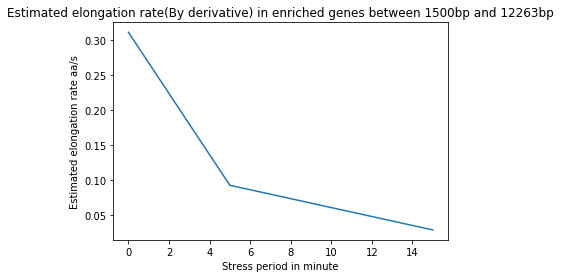

In [44]:
fig = plt.figure()
ax = plt.axes()
x = [0,5,15]
ax.plot(x, rate)
plt.title("Estimated elongation rate(By derivative) in " +dhh1_tag+ " genes between " + str(d1) + "bp and " + str(d2)+ "bp")
plt.xlabel("Stress period in minute")
plt.ylabel("Estimated elongation rate aa/s");

In [45]:
fig = go.Figure()
rate = []
for i in range(1,len(select_times)):
    t = select_times[i] +'_est_elong'
    sample_color = colors[i]
    x = np.array(df_est.index).reshape(-1, 1)
    raw_y = np.array(df_est.loc[:,t]).reshape(-1, 1)
    
    model = LinearRegression()
    result=model.fit(x, raw_y)

    # predict y from the data
    fit_y = model.predict(x)
    print('coefficient of determination R^2 of the prediction is :', result.score(x, raw_y))
    rate.append(1/(model.coef_.reshape(-1)[0]))
    fig.add_trace(go.Scatter(mode='markers',x = x.reshape(-1),y = raw_y.reshape(-1),marker=dict(color=sample_color,size = 4),name= t))
    fig.add_trace(go.Scatter(mode='lines',x = x.reshape(-1),y = fit_y.reshape(-1),line=dict(color=sample_color)))
    
fig.update_layout(
    template='simple_white',
    title_text="Estimated elongation rate(By increment) in first L codons in " +dhh1_tag+ " genes between " + str(d1) + "bp and " + str(d2)+ "bp",
    yaxis_title="Estimated elongation rate in aa/sec",
    xaxis_title="L values (in codon)"
)       

fig.show() 

coefficient of determination R^2 of the prediction is : 0.03926116751996922
coefficient of determination R^2 of the prediction is : 0.05631839160941332
coefficient of determination R^2 of the prediction is : 0.015417066506167807
